In [1]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas
from keras import Sequential
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
import keras.callbacks as callbacks

Using TensorFlow backend.


input1 = Missing image (Masked by cloud)

input2 = Referenced images (cloud-free)

### Implement Model

In [2]:
input1 = Input(shape=(400,400,1), name='input1')
input2 = Input(shape=(400,400,1), name='input2')

conv_1 = Conv2D(30, (3, 3),padding='same')(input1)
conv_2 = Conv2D(30, (3, 3),padding='same')(input2)

concat_1_2 = concatenate([conv_1, conv_2], axis=-1)
concat_1_2 = Activation('relu')(concat_1_2)

concat_1_2 = Dropout(0.5)(concat_1_2)

feature_3 = Conv2D(filters=20, kernel_size=(3, 3),padding='same')(concat_1_2)
feature_5 = Conv2D(filters=20, kernel_size=(5, 5),padding='same')(concat_1_2)
feature_7 = Conv2D(filters=20, kernel_size=(7, 7),padding='same')(concat_1_2)
feature_3_5_7 = concatenate([feature_3, feature_5, feature_7])
feature_3_5_7 = Activation('relu')(feature_3_5_7)

feature_3_5_7 = Dropout(0.5)(feature_3_5_7)

sum0 = add([concat_1_2, feature_3_5_7])

conv1 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum0)
conv2 = Conv2D(filters=30, kernel_size=(3,3), padding='same',activation='relu')(conv1)

sum1 = add([conv_2, conv2])
conv3 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(sum1)
conv4 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=3, padding='same',activation='relu')(conv3)
conv5 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(conv4)
sum2 = add([conv3, conv5])

conv6 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum2)
conv6 = Dropout(0.5)(conv6)

conv7 = Conv2D(filters=1, kernel_size=(3,3), padding='same')(conv6)

model = Model([input1, input2], conv7)
    

#### Define PSNR Loss Metrics, remains loss function MSE ; Step Decay for Callbacks

In [3]:
def PSNRLoss(y_true, y_pred):
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

In [4]:
def step_decay(epoch):
    initial_lrate = 0.0003
    drop = 0.5
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

## Read dataset

In [5]:
import h5py

f = h5py.File('small_train.hdf5', 'r')
trainY = f['label'][:]
trainX_1 = f['masked'][:]
trainX_2 = f['ref'][:]
f.close()


f = h5py.File('small_test.hdf5', 'r')
testY = f['label'][:]
testX_1 = f['masked'][:]
testX_2 = f['ref'][:]
f.close()

### Config Model

In [9]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 
model.compile(optimizer=adam, loss='mean_squared_error', metrics=[PSNRLoss])

batch_size = 1
nb_epoch = 50

img_rows, img_cols = 400, 400
out_rows, out_cols = 400, 400

lrate = LearningRateScheduler(step_decay)
callback_list = [callbacks.ModelCheckpoint('weight.h5', monitor='val_PSNRLoss', save_best_only=True,
                                           mode='max', save_weights_only=True, verbose=2)]

history = model.fit([trainX_1,trainX_2], trainY, batch_size=batch_size, epochs=nb_epoch, callbacks=callback_list,
                    verbose=1, validation_data=([testX_1, testX_2], testY))  

Train on 810 samples, validate on 540 samples
Epoch 1/50
810/810 [==============================] - 1015s 1s/step - loss: 0.0071 - PSNRLoss: 43.8333 - val_loss: 0.0070 - val_PSNRLoss: 47.2168

Epoch 00001: val_PSNRLoss improved from -inf to 47.21681, saving model to weight.h5
Epoch 2/50
810/810 [==============================] - 1000s 1s/step - loss: 0.0046 - PSNRLoss: 44.0314 - val_loss: 0.0055 - val_PSNRLoss: 51.9293

Epoch 00002: val_PSNRLoss improved from 47.21681 to 51.92927, saving model to weight.h5
Epoch 3/50
810/810 [==============================] - 1001s 1s/step - loss: 0.0038 - PSNRLoss: 43.8542 - val_loss: 0.0069 - val_PSNRLoss: 49.9756

Epoch 00003: val_PSNRLoss did not improve from 51.92927
Epoch 4/50
810/810 [==============================] - 1004s 1s/step - loss: 0.0031 - PSNRLoss: 43.7108 - val_loss: 0.0061 - val_PSNRLoss: 45.6037

Epoch 00004: val_PSNRLoss did not improve from 51.92927
Epoch 5/50
810/810 [==============================] - 1001s 1s/step - loss: 0.0032

810/810 [==============================] - 991s 1s/step - loss: 0.0013 - PSNRLoss: 41.9602 - val_loss: 0.0043 - val_PSNRLoss: 53.2174

Epoch 00040: val_PSNRLoss did not improve from 53.27788
Epoch 41/50
810/810 [==============================] - 991s 1s/step - loss: 0.0013 - PSNRLoss: 41.9748 - val_loss: 0.0070 - val_PSNRLoss: 52.5150

Epoch 00041: val_PSNRLoss did not improve from 53.27788
Epoch 42/50
810/810 [==============================] - 991s 1s/step - loss: 0.0012 - PSNRLoss: 42.1653 - val_loss: 0.0089 - val_PSNRLoss: 48.9907

Epoch 00042: val_PSNRLoss did not improve from 53.27788
Epoch 43/50
810/810 [==============================] - 991s 1s/step - loss: 0.0012 - PSNRLoss: 42.2363 - val_loss: 0.0077 - val_PSNRLoss: 53.2458

Epoch 00043: val_PSNRLoss did not improve from 53.27788
Epoch 44/50
810/810 [==============================] - 991s 1s/step - loss: 0.0012 - PSNRLoss: 42.4172 - val_loss: 0.0099 - val_PSNRLoss: 52.9511

Epoch 00044: val_PSNRLoss did not improve from 53.277

In [17]:
y_pred = model.predict([testX_1[:1], testX_2[:1]])

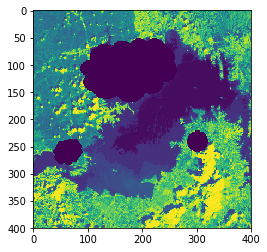

In [21]:
plt.imshow(testX_1[0,:,:,0])

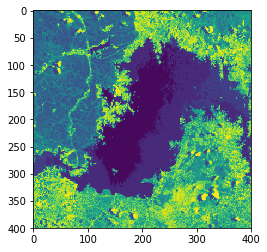

In [22]:
plt.imshow(testX_2[0,:,:,0])

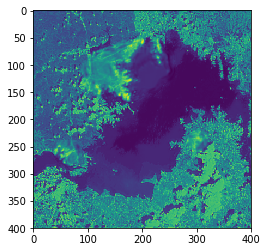

In [23]:
plt.imshow(y_pred[0,:,:,0])

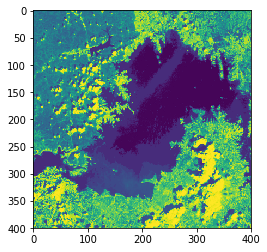

In [24]:
plt.imshow(testY[0,:,:,0])

In [11]:
print(history.history.keys())

dict_keys(['loss', 'val_PSNRLoss', 'val_loss', 'PSNRLoss'])


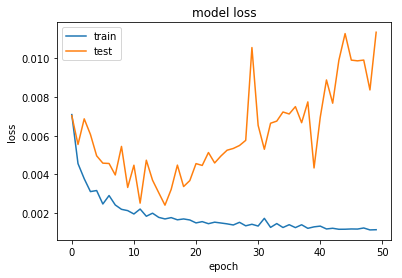

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

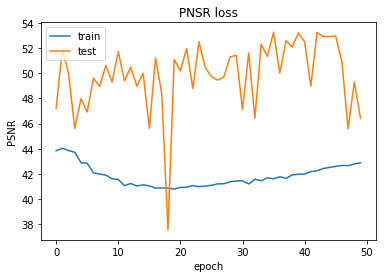

In [15]:
# summarize history for loss
plt.plot(history.history['PSNRLoss'])
plt.plot(history.history['val_PSNRLoss'])
plt.title('PNSR loss')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()